In [1]:
from lmnav.config.default import get_config
from habitat.core.registry import registry as registry
from lmnav.common.actor_setups import setup_karmesh_eai_teacher
from functools import partial
import pickle
import os
import torch.multiprocessing as mp
import gc
import torch
import copy
import pympler as muppy
import numpy as np
from collections import namedtuple
import cv2
from tqdm import tqdm

os.chdir("/srv/flash1/pputta7/projects/lm-nav")

[2023-10-25 17:24:31,617] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


## Util Stuff

In [2]:
import gzip
import pickle
import os
import numpy as np
from habitat_baselines.utils.common import batch_obs, generate_video
from habitat.core.logging import logger
from habitat.core.utils import try_cv2_import,tile_images
from habitat.utils.common import flatten_dict
from habitat.utils.visualizations import maps
import cv2

def observations_to_image(observation, info) :
    r"""Generate image of single frame from observation and info
    returned from a single environment step().

    Args:
        observation: observation returned from an environment step().
        info: info returned from an environment step().

    Returns:
        generated image of a single frame.
    """
    render_obs_images = []
    for sensor_name in observation:
        if len(observation[sensor_name].shape) > 1:
            obs_k = observation[sensor_name]
            if not isinstance(obs_k, np.ndarray):
                obs_k = obs_k.cpu().numpy()
            if obs_k.dtype != np.uint8:
                obs_k = obs_k * 255.0
                obs_k = obs_k.astype(np.uint8)
            if obs_k.shape[2] == 1:
                obs_k = np.concatenate([obs_k for _ in range(3)], axis=2)
            render_obs_images.append(obs_k)

    assert (
        len(render_obs_images) > 0
    ), "Expected at least one visual sensor enabled."

    shapes_are_equal = len(set(x.shape for x in render_obs_images)) == 1
    if not shapes_are_equal:
        render_frame = tile_images(render_obs_images)
    else:
        render_frame = np.concatenate(render_obs_images, axis=1)

    # draw collision
    collisions_key = "collisions"
    if collisions_key in info and info[collisions_key]["is_collision"]:
        render_frame = draw_collision(render_frame)

    top_down_map_key = "top_down_map"
    if top_down_map_key in info:
        top_down_map = maps.colorize_draw_agent_and_fit_to_height(
            info[top_down_map_key], render_frame.shape[0]
        )
        render_frame = np.concatenate((render_frame, top_down_map), axis=1)

    action_prob_keys = "act_probs"
    if action_prob_keys in info:
        ap = info[action_prob_keys].tolist()
        txt = " ".join([f"{a}: {p:.2f}" for a, p in zip("SFLR", ap)])
        render_frame = draw_text_box(render_frame, txt, 0, -200)

    frame_idx_key = "frame_idx"
    if frame_idx_key in info:
        render_frame = draw_text_box(render_frame, f"Frame: {info[frame_idx_key]}", 0, -150)
    
    return render_frame


import cv2
import numpy as np

def draw_text_box(frame, text, x_offset, y_offset):
    # Convert frame to BGR format (OpenCV uses BGR by default)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    # Define font parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)  # White color
    font_thickness = 2

    # Get the size of the text
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    
    # Calculate the size of the text box
    box_width = text_size[0] + 20  # Add some padding
    box_height = text_size[1] + 20  # Add some padding

    # Calculate the center of the frame
    center_x = frame.shape[1] // 2
    center_y = frame.shape[0] // 2

    # Calculate the coordinates to center the box with offsets
    box_x = center_x - (box_width // 2) + x_offset
    box_y = center_y - (box_height // 2) + y_offset

    # Draw the box
    cv2.rectangle(frame, (box_x, box_y), (box_x + box_width, box_y + box_height), (0, 0, 255), -1)

    # Calculate the position to center the text
    text_x = box_x + 10  # Add some left padding
    text_y = box_y + text_size[1] + 10  # Add some top padding

    # Put the text on the frame
    cv2.putText(frame, text, (text_x, text_y), font, font_scale, font_color, font_thickness)

    return frame

def construct_vid(observations):
    frames = [observations_to_image(obs['observation'], {'act_probs': obs['probs'], 'top_down_map': obs['info']['top_down_map'], 'frame_idx': i}) for i, obs in enumerate(observations)]
    return frames

In [12]:
config = get_config("datagen/imagenav_karmesh_data_gen_10envs")
config.habitat_baselines.num_environments = 1
config.habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.width = 256
config.habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.height = 256

env = make_gym_from_config(config)

2023-10-25 17:27:13,863 Initializing dataset PointNav-v1


Initializing environment on gpu: 0
[2023-10-25 17:27:19,572] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-10-25 17:27:20,036 Initializing dataset PointNav-v1
2023-10-25 17:27:23,531 initializing sim Sim-v0
2023-10-25 17:27:25,035 Initializing task Nav-v0


## Fun Stuff

In [15]:
@registry.register_dataset(name="Traj-v1")

['__annotations__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_reset_done',
 '_batch_renderer',
 '_connection_read_fns',
 '_connection_write_fns',
 '_is_closed',
 '_mp_ctx',
 '_num_envs',
 '_paused',
 '_spawn_workers',
 '_valid_start_methods',
 '_warn_cuda_tensors',
 '_worker_env',
 '_workers',
 'action_spaces',
 'async_step',
 'async_step_at',
 'call',
 'call_at',
 'close',
 'count_episodes',
 'current_episodes',
 'episode_over',
 'get_metrics',
 'initialize_batch_renderer',
 'num_envs',
 'number_of_episodes',
 'observation_spaces',
 'orig_action_spaces',
 'pause_at',
 'post_step',
 'render',
 'reset',
 'reset_at',
 '

In [4]:
benv = env.env.env
episodes = benv._env._dataset.episodes

class EnvSpec:
    def __init__(self, a, b):
        self.observation_space = a
        self.action_space = b
env_spec = EnvSpec(a = env.observation_space, b=env.action_space)
teacher = setup_karmesh_eai_teacher(config, env_spec)

2023-10-25 17:24:40,373 Resizing observation of imagegoal: from (256, 256) to (128, 128)
2023-10-25 17:24:40,375 Resizing observation of rgb: from (256, 256) to (128, 128)


setting up eai teacher...
done setting up eai teacher...


In [5]:
for i, episode in enumerate(episodes[500:600], start=500):
    print(i, episode.info['geodesic_distance'])

500 5.595616340637207
501 5.997106075286865
502 2.7102558612823486
503 5.709062576293945
504 1.7343171834945679
505 3.284414291381836
506 6.315406799316406
507 4.062166213989258
508 7.062810897827148
509 2.6766138076782227
510 2.8801445960998535
511 3.9378085136413574
512 2.838696002960205
513 1.7967090606689453
514 4.623208045959473
515 4.853151321411133
516 1.7752342224121094
517 2.3214571475982666
518 2.684134006500244
519 3.126512050628662
520 6.016928672790527
521 5.558073043823242
522 8.48515796661377
523 2.5445902347564697
524 8.202153205871582
525 8.590860366821289
526 2.6534128189086914
527 5.188305854797363
528 6.628355026245117
529 5.193456649780273
530 3.897495985031128
531 2.621054172515869
532 2.80124568939209
533 8.730704307556152
534 1.6467349529266357
535 2.4605085849761963
536 6.891119003295898
537 3.5499463081359863
538 4.244623184204102
539 9.6370849609375
540 3.4414634704589844
541 6.938620567321777
542 2.454442024230957
543 4.432961940765381
544 2.6833109855651855

In [32]:
def gen_obs(idx):
    env.env.env._env.current_episode = episodes[idx]
    env.env.env._env._episode_from_iter_on_reset = False
    actor = teacher.action_generator(1, deterministic=False)
    obs = env.reset()
    done = False
    step = 0
    
    data = []
    with tqdm(total=500) as pbar:
        while not done or step >= 500: 
            # roll out a step
            next(actor)
            actions, probs = actor.send(([obs], [done]))
            step_data = [a.item() for a in actions.cpu()]
        
            outputs = env.step(step_data[0])
            next_observations, rewards_l, done, infos = outputs
        
            # insert episode into list
            
            data.append({
                   'observation': {k: torch.from_numpy(v).clone() for k, v in obs.items() if k != "depth"},
                    'reward': rewards_l,
                    'info': {k: torch.from_numpy(v).clone() if isinstance(v, np.ndarray) else v for k, v in infos.items()},
                    'action': step_data,
                    'probs': probs[0].cpu()
                })
            obs = next_observations
            step += 1

            pbar.update(1)
        
        print("Done in", step, "steps")
    return data

In [33]:
datas = []
while len(datas) < 10:
    try:
        datas.append(gen_obs())
    except Exception as e:
        print("there was an error, but continuing", e)

[14:31:12:518201]:[Warning]:[Assets] ResourceManager.cpp(353)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SceneInstanceAttributes-provided name : `data/scene_datasets/hm3d/train/00494-5737gQA9p2T/5737gQA9p2T.basis.scn` nor constructed filename : `data/scene_datasets/hm3d/train/00494-5737gQA9p2T/info_semantic.json` exist on disk.
[14:31:13:515108]:[Warning]:[Sim] Simulator.cpp(508)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0
  0%|                                                                | 0/500 [00:00<?, ?it/s]/coc/testnvme/pputta7/mambaforge/envs/lmnav/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass an

Done in 80 steps


  7%|████                                                   | 37/500 [00:02<00:31, 14.68it/s]


Done in 37 steps


 11%|██████                                                 | 55/500 [00:03<00:30, 14.70it/s]


Done in 55 steps


  8%|████▎                                                  | 39/500 [00:02<00:31, 14.57it/s]


Done in 39 steps


 12%|██████▍                                                | 58/500 [00:03<00:30, 14.61it/s]


Done in 58 steps


 17%|█████████▎                                             | 85/500 [00:05<00:28, 14.51it/s]


Done in 85 steps


 11%|█████▊                                                 | 53/500 [00:03<00:30, 14.57it/s]


Done in 53 steps


 20%|██████████▊                                           | 100/500 [00:07<00:28, 14.22it/s]


Done in 100 steps


 11%|██████                                                 | 55/500 [00:03<00:31, 14.24it/s]


Done in 55 steps


 29%|███████████████▌                                      | 144/500 [00:09<00:24, 14.60it/s]

Done in 144 steps


In [17]:
all_frames = []
for i, data in enumerate(datas):
    frames = construct_vid(data)
    all_frames.append(frames)
    # Convert frames to video using OpenCV
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # FourCC code for .mp4
    out = cv2.VideoWriter(f'tmpvideos/{i}-output.mp4', fourcc, 3.0, (1130, 256))
    
    for frame in frames:
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to BGR
        upscaled_frame = cv2.resize(bgr_frame, (1130, 256))  # Upscale to double size
        out.write(upscaled_frame)
    
    out.release()

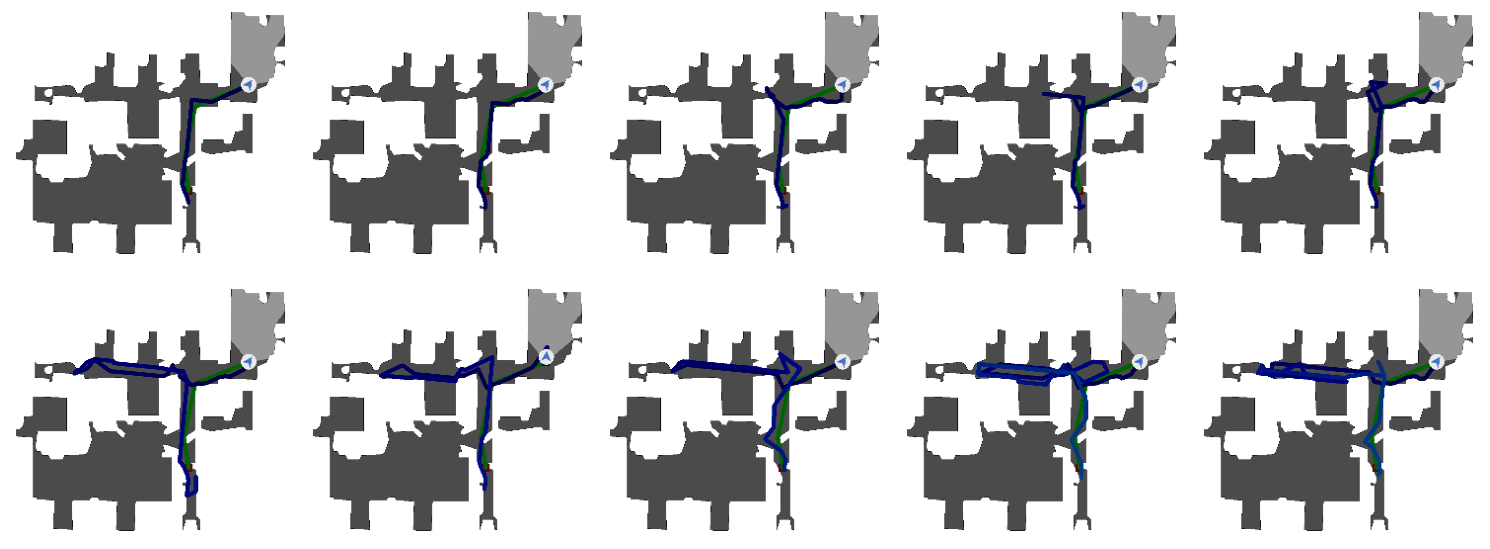

In [34]:
from matplotlib import pyplot as plt

images = [frame[0][:, 512:] for frame in all_frames]
# Display the cropped images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, img in zip(axes.ravel(), images):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [30]:
all_frames.sort(key=lambda x: len(x))